#Práctica 3: Clasificación (NB-DT-SVM)




*Máster en Ciencia de Datos y Aprendizaje Automático - Universidad de La Rioja*

Durante el desarrollo de esta práctica, resuelve los ejercicios en este cuaderno justo después de ser propuestos.

Se valorará positivamente la documentación en las respuestas y la explicación de las mismas.

No olvides guardar tus versiones intermedias en GitHub (menú "Archivo" >> "Guardar una copia en GitHub") y la definitiva antes de la fecha límite de entrega.

Como podemos intuir de las prácticas anteriores para usar un modelo de la librería sklearn siempre se usa la misma estructura:
*     se separan los datos de entrenamiento y de test
*     se crea el modelo, cambiando los hiperparámetros en este punto si fuera necesario: *model=modeloEjemplo()*
*     se construye el modelo con los datos de entrenamiento: *model.fit(X_train, y_train)*
*     se usa el modelo para poder predecir la clase del conjunto de test: *y_pred=model.predict(X_test)*
*     se evalúa si el modelo ha funcionado usando alguna de las métricas de evaluación

Bibliografía:
* Dataset Iris: https://archive.ics.uci.edu/dataset/53/iris
* Naive Bayes: https://towardsdatascience.com/implementing-naive-bayes-in-2-minutes-with-python-3ecd788803fe
* Dataset fetch_20newsgroups: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
* SVM: https://towardsdatascience.com/svm-hyperparameters-explained-with-visualizations-143e48cb701b
* SVM Classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC


##Naive Bayes:

###Gaussian Naive Bayes

Preparamos el dataset. En este caso, para usarlo como ejemplo vamos a coger el dataset "Iris", este conjunto tiene información sobre 3 tipos de plantas ([más info](https://archive.ics.uci.edu/ml/datasets/iris))

In [2]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

data=load_iris()
# convertimos la variable data a otra variable de tipo DataFrame para porder trabajar con ella mejor
dataIris = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])
# partimos los datos en tres variables:
X,y,column_names=data['data'], data['target'],data['feature_names']
X=pd.DataFrame(X, columns =column_names)



In [3]:
# Verificar el balanceo de clases en la variable objetivo 'y'
class_counts = pd.Series(y).value_counts()
print("Recuento de clases:\n", class_counts)

# Calcular el porcentaje de cada clase
class_percentages = class_counts / len(y) * 100
print("\nPorcentaje de cada clase:\n", class_percentages)

Recuento de clases:
 0    50
1    50
2    50
Name: count, dtype: int64

Porcentaje de cada clase:
 0    33.333333
1    33.333333
2    33.333333
Name: count, dtype: float64


EJERCICIO: Comprueba y dí si el conjunto de datos está balanceado para las tres clases que tiene.

RESPUESTA: Hay 50 instancias de caad clase, así que se puede afirmar que el conjunto de datos está perfectamente balanceado.

In [16]:
print(dataIris.groupby('target').size())

target
0.0    50
1.0    50
2.0    50
dtype: int64


EJERCICIO: Completa el código para obtener los conjuntos de entrenamiento y de test con un porcentaje de 75-25 respectivamente. Para estos ejemplos no vamos a usar el conjunto de validación.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size = 0.75,random_state= 42, shuffle=True, stratify= y)

Para entender un poco mejor como funciona este método en lugar de usar directamente la función que nos proporciona *sklearn*, vamos a implementarlo.

Agrupamos el conjunto de entrenamiento por clase y calculamos la media y la desviación estándar para cada columna agrupada por clase.

También se calcula la clase de probabilidades 'previa', lo cual es simplemente el número de elementos de una clase dividido por el número de elementos del conjunto de entrenamiento

In [21]:
means=X_train.groupby(y_train).apply(lambda x: x.mean(axis=0))
stds=X_train.groupby(y_train).apply(np.std)
print("***** media de cada descriptor para cada clase*****")
print(means)
print("***** desviación estándar de cada descriptor para cada clase*****")
print(stds)


***** media de cada descriptor para cada clase*****
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           4.884615          3.353846           1.476923          0.238462
1           5.916667          2.658333           4.175000          1.241667
2           6.716667          2.950000           5.758333          2.000000
***** desviación estándar de cada descriptor para cada clase*****
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.300886          0.329604           0.180401          0.133235
1           0.642694          0.368462           0.558458          0.180085
2           0.668123          0.368556           0.625111          0.264575


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [22]:
# class prior probabilities
probs=X_train.groupby(y_train).apply(lambda x: len(x))/X_train.shape[0]
print("***** probabilidad previa para cada clase*****")
print(probs)

***** probabilidad previa para cada clase*****
0    0.351351
1    0.324324
2    0.324324
dtype: float64


PREGUNTA:  ¿cuál crees que es la razón por la que la probabilidad de que ocurra cada clase es del 33% aproximadamente?

RESPUESTA: Esto se debe a que hay un 33% de datos de cada clase.

Una vez tenemos la media, la desviación estándar y la probabilidad 'previa' de cada clase calculada seguimos implementando el método:

In [23]:
from scipy.stats import norm

y_pred=[]
# para cada elemento del conjunto de test
for elem in range(X_test.shape[0]):
  p={}

  # para cada clase posible
  for c1 in np.unique(y_train):

    #tomar la probabilidad previa de cada clase
    p[c1]=probs.iloc[c1]

    #para cada columna en el conjunto de datos
    for index, param in enumerate(X_test.iloc[elem]):

      #multiplicar por la probabilidad de dado un valor de una columna este pertenezca a la
      #distribución de la columna del conjunto de entrenamiento de la clase dada
      p[c1]*= norm.pdf(param, means.iloc[c1,index],stds.iloc[c1,index])
  #calcuar la predicción del elemento
  y_pred.append(pd.Series(p).values.argmax())

EJERCICIO: calcula la *accuracy* para el modelo que hemos creado con los datos obtenidos

In [24]:
# Evaluamos el clasificador creado usando la métrica accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9380530973451328

EJERCICIO: realiza lo mismo, utilizando ahora el método que proporciona *sklearn* para este modelo de clasificación (*GaussianNB*), apóyate en la ayuda para utilizarlo. Puedes usarlo con los hiperparámetros por defecto.

Si lo has hecho correctamente, ha de salirte el mismo valor de *accuracy*.


In [25]:
# sklearn classifier
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9380530973451328

No sólo hay el método *Gaussian Naive Bayes*, dependiendo de la distribución de los datos existen otros métodos que se pueden aplicar:

*   Multinomial Naive Bayes
*   Complement Naive Bayes
*   Bernoulli Naive Bayes
*   Categorical Naive Bayes

El método Multinomial Naive Bayes se usa a menudo en clasificación de texto, veamos un ejemplo.

###Multinomial Naive Bayes


Un lugar donde a menudo se usa Naïve Bayes multinomial es en la clasificación de texto, donde las características están relacionadas con el recuento de palabras o su frecuencia dentro de los documentos que se van a clasificar.

Para ver un ejemplo vamos a usar uno de los dataset que da *sklearn* como ejemplo, [más info](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html).

In [26]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Para simplificar aquí, seleccionaremos solo algunas de estas categorías y descargaremos el conjunto de train y test usando el parámetro *subset*.

In [27]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Veamos lo que contiene una instancia:

In [28]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Para usar este tipo de datos en aprendizaje automático, necesitamos poder convertir el contenido de cada cadena en un vector de números. Para esto usaremos el vectorizador TF-IDF, y crearemos una 'tubería' (*pipeline*) que lo adjunte a nuestro clasificador.

Los recuentos de palabras sin procesar dan lugar a características que dan demasiada importancia a las palabras que aparecen con mucha frecuencia, y esto puede ser subóptimo en algunos algoritmos de clasificación. Una opción para solucionar este problema es la conocida como  *término frecuencia-frecuencia inversa del documento* (TF-IDF), que pondera los recuentos de palabras según la frecuencia con la que aparecen en los documentos.

Frecuencia temporal (TF) = (Cantidad de veces que aparece el término t en un documento) / (Número de términos en el documento) Frecuencia inversa del documento (IDF) = log (N / n), donde, N es el número de documentos y n es el número de documentos que tiene un término t. La IDF de una palabra rara es alta, mientras que la IDF de una palabra común es probable que sea baja. Teniendo así el efecto de resaltar palabras que son distintas. Calculamos el *TF-IDF valor* de un término como = TF * IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Así, podemos aplicar el modelo a los datos de entrenamiento y predecir etiquetas para los datos de test:

EJERCICIO: Entrena el modelo anterior (model) sobre el conjunto de entrenamiento (train.data, train.target) y obtén la predicción del conjunto de test (test.data)

In [30]:
model.fit(train.data, train.target)
labels = model.predict(test.data)
print(accuracy_score(test.target,labels))

0.8016759776536313


El siguiente código muestra la matriz de confusión:

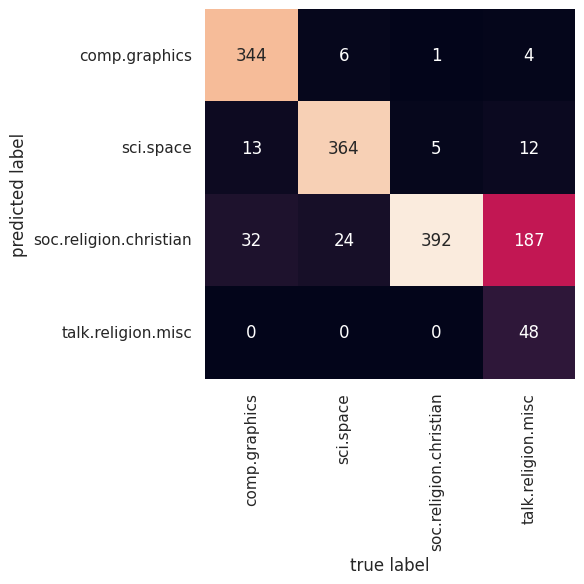

In [31]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Ahora, lo que tenemos es la herramienta para determinar la categoría de cualquier cadena, usando el método predict ().

A continuación, creamos una función para utilizar esta herramienta de manera rápida y que devuelva la predicción para una sola cadena.

In [32]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

EJERCICIO: utiliza esta función para obtener la predicción sobre el tema que hablan las siguientes frases:
*       sending a payload to the ISS
*       discussing about a pie chart

In [37]:
# predict_category(...)
print('Category ss: ' + predict_category("sending a payload to the ISS"))
print('Category pie chart: ' + predict_category("discussing about a pie chart"))

Category ss: sci.space
Category pie chart: comp.graphics


EJERCICIO: prueba con otra sentencia y mira cómo la clasifica (recuerda que has de escribirla en inglés).

In [39]:
predict_category('god is great')

'soc.religion.christian'

##Árbol de Decisión

Veamos ahora cómo podemos usar el modelo de clasificación "Árbol de Decisión" o "*Decision Tree*".

Al igual que para el primer ejemplo (Naïve Bayes) en este caso vamos a trabajar con el conjunto de datos más popular en el campo del aprendizaje automático, el conjunto Iris (UC Irvine).

Cargamos los datos y separamos característica objetivo del resto de caracteristicas.

In [40]:
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Categorical.from_codes(iris.target, iris.target_names)

EJERCICIO: Comprueba cómo es el conjunto de datos, observando cómo son las 5 primeras instancias.

In [54]:
y

['setosa', 'setosa', 'setosa', 'setosa', 'setosa', ..., 'virginica', 'virginica', 'virginica', 'virginica', 'virginica']
Length: 150
Categories (3, object): ['setosa', 'versicolor', 'virginica']

In [45]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


EJERCICIO: Completa para obtener el conjunto de entrenamiento y de

---

test. Fija una semilla de 1 para el parámetro que controla la aleatoriedad.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.8, random_state= 1)

EJERCICIO: completa el código para crear y entrenar un modelo de árbol de decisión. Fija una semilla de 15 para el parámetro que controla la aleatoriedad.


In [59]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=15)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=15)

Una vez creado y entrenado el modelo podemos ver el árbol de decisión real que se ha producido. Para ello usamos el siguiente código.

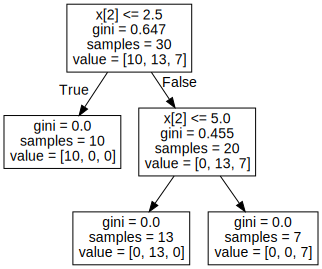

In [60]:
from sklearn import tree
import graphviz
tree=tree.export_graphviz(dt)
graphviz.Source(tree)

EJERCICIO: sin usar la función predic, viendo el árbol que hemos creado, ¿qué clase obtendríamos para la siguiente instancia?
sepal length=4.6
sepat width=3.4
petal length= 2.8
petal width= 0.3

RESPUESTA: Para esos valores según el árbol de decisión se obtendría un valor: setosa

EJERCICIO: obtén las predicciones para el conjunto de test.

In [61]:
pred =dt.predict(X_test)

EJERCICIO: evalúa el modelo generando la matriz de confusión y calculando su recall, precision, accuracy y F1-score.

¿Basándote en las métricas, dirías que es un modelo bueno?

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
#matriz de confusion
cm = confusion_matrix(y_test, pred)
print("Matriz de confusion:\n", cm)

# Otras metricas
report = classification_report(y_test, pred)
print("\nMetricas:\n", report)


Matriz de confusion:
 [[40  0  0]
 [ 0 36  1]
 [ 0  9 34]]

Metricas:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.80      0.97      0.88        37
   virginica       0.97      0.79      0.87        43

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.93      0.92      0.92       120



Básandome en las métricas diría que es un buen modelo ya que tiene unos porcentajes de acierto bastante altos. Solo falla un poco con la identificación de las flores de virginica.

## Support Vector Machine (SVM)

Support vector machines (SVMs) es un método de aprendizaje supervisado, durante las siguientes secciones veremos la idea que hay detrás de los SVMs y su uso en problemas de clasificación.

Cargamos algunas de las librerías que vamos a necesitar.

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

### **Idea**: Support Vector Machines

La principal idea es encontrar un hiperplano (una línea en 2 dimensiones, un plano en 3 dimensiones o un hiperplano en más) que separe las instancias en dos clases.

Para hacernos a la idea de cómo funciona, vamos a pensar en el caso más simple de clasificación, en el cual dos clases de puntos se encuentran bien separadas.

Creamos un conjunto de datos aleatorio con dos clases y 50 muestras.

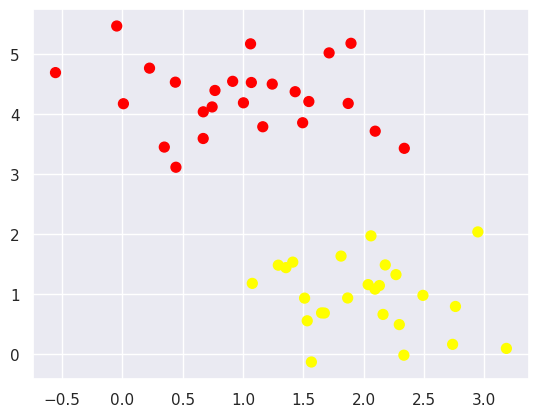

In [67]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

La idea es encontrar una línea que separe el conjunto de datos en dos clases y así crear un modelo de clasificación. En este caso sencillo se podría hacer incluso a mano, pero en seguida nos damos cuenta de que nos encontramos un problema. Hay más de una línea posible.

Dibujamos algunas:

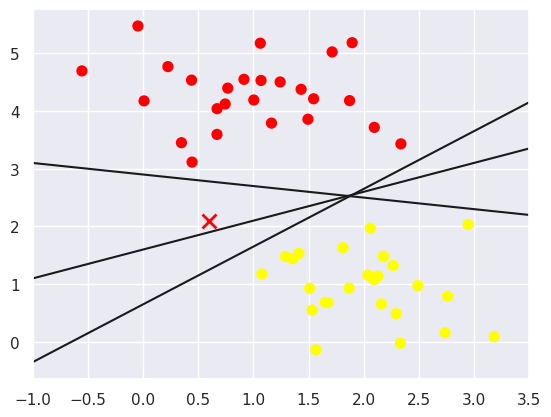

In [68]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Cualquiera de las tres separa los datos completamente.

Si introducimos un nuevo dato (el dato x) vemos que será asignado a una clase u otra según la línea que se haya escogido.

Entonces, ¿cuál de todas las lineas posibles es la más óptima? Veamos cómo se elije.

### Maximizando el *Margen*

Para cada línea vamos a dibujar el área que hay entre la línea y las líneas paralelas que pasan por el punto más cercano para cada clase. Este área es lo que se denomina *margen*.

Ejecuta el siguiente código para visualizar la idea.

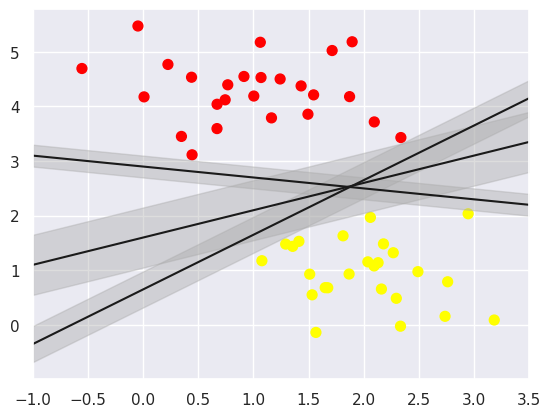

In [69]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Como se puede intuir la línea óptima es la línea que maximiza el margen y es la que será elegida para crear el modelo.

### Ajustar un support vector machine


Usaremos el método SVC de la librería Scikit-Learn ya que lo que tenemos es un problema de clasificación (Support Vector Classifier).


EJERCICIO: completa el código para obtener el modelo con kernel = linear y el valor de C = 1E10. Considera X e y como el conjunto de entrenamiento.

In [70]:
from sklearn.svm import SVC # "Support vector classifier"
#.......................
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Para una mejor visualización de lo que está ocurriendo, creamos una función que dibujará la frontera de decisión del SVM.

In [71]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

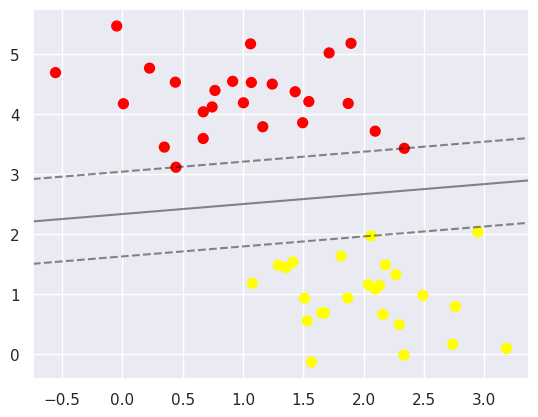

In [72]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Así podemos ver cuál es la frontera de decisión que maximiza el margen entre los dos conjuntos de puntos.

Notar que hay algunos puntos que tocan el margen, a estos puntos se les denomina *support vectors* y son los que dan nombre al algoritmo.

En Scikit-Learn, se almacena la identidad de estos puntos en el atributo ``support_vectors_`` del clasificador.

In [73]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Una clave del éxito de este clasificador es que para el ajuste, solo importa la posición de los vectores de soporte. ¡Cualquier punto más alejado del margen que esté en el lado correcto no modifica el ajuste! Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdida utilizada para ajustar el modelo, por lo que su posición y número no importan siempre que no crucen el margen.

Podemos ver esto, por ejemplo, si graficamos el modelo aprendido de los primeros 60 puntos y los primeros 120 puntos de este conjunto de datos:

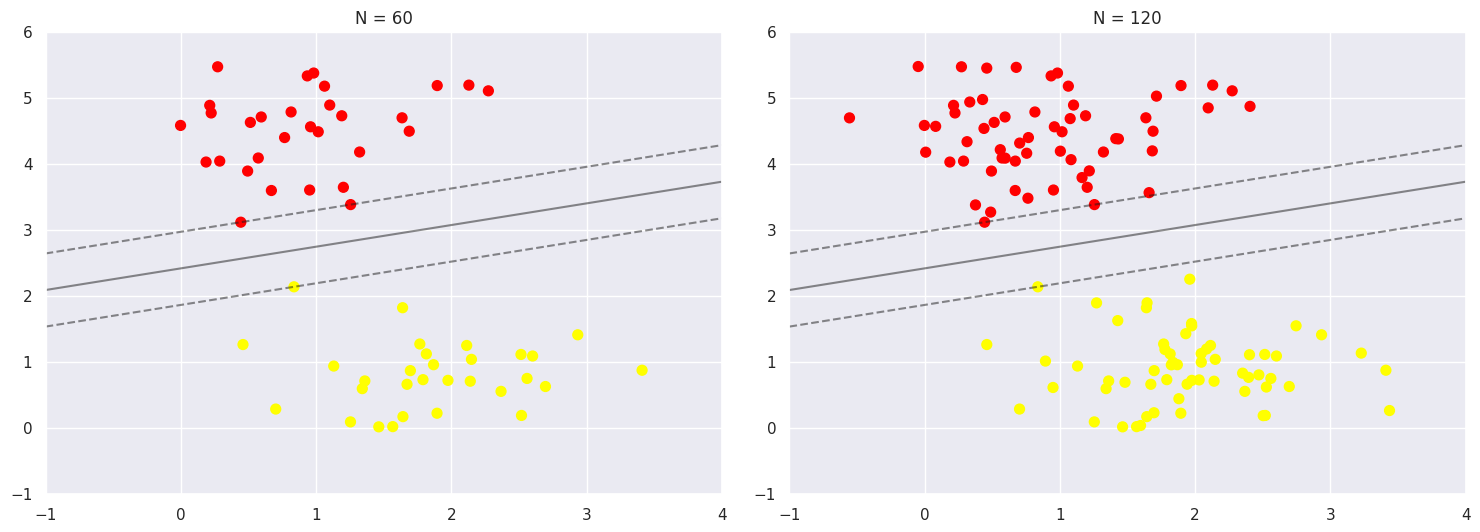

In [74]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

En la parte de la izquierda podemos ver el modelo y los support vectors para el entrenamiento con 60 puntos. A la derecha tenemos el resultado de crear un modelo partiendo del doble de puntos que en la izquierda (120 puntos). Hemos aumentado la cantidad de puntos pero el modelo no ha cambiado, esto ocurre porque los tres puntos que son support vectors en la gráfica de la izquierda, lo siguen siendo en la gráfica de la derecha. Esta característica del modelo, la insensibilidad en el comportamiento que muestra al aumentar el número de instancias en la muestra es uno de los puntos fuertes del modelo SVM.

Puedes ver lo que acabamos de describir de manera interactiva con el siguiente código.

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

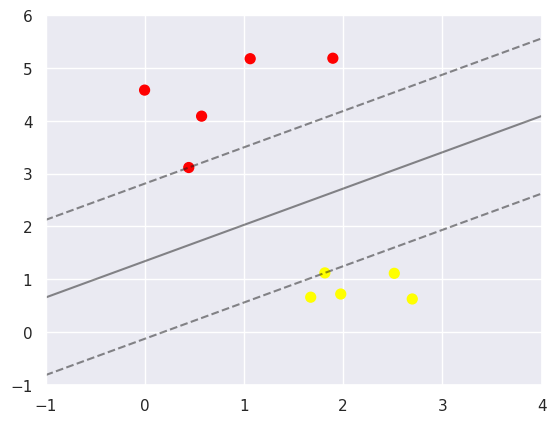

In [75]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

#### Ajustando los márgenes:

No siempre los datos están limpios y claramente separables.
Hasta ahora, nuestra discusión se ha centrado en conjuntos de datos muy limpios, en los que existe un límite de decisión perfecto.
Pero, ¿qué pasa si sus datos tienen cierta superposición?
Por ejemplo, veamos el siguiente conjunto de datos:

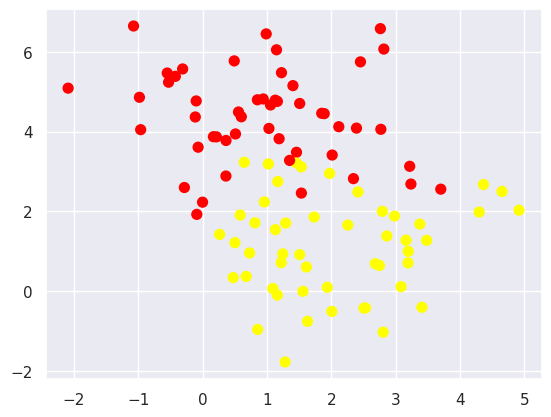

In [76]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Para este tipo de situaciones, SVM tiene un factor que "suaviza" el margen: es decir, permite que algunos de los puntos se introduzcan en el margen si eso permite un mejor ajuste.

La permisividad del margen se controla mediante un parámetro de ajuste conocido como C.

Para un valor de C muy grande, el margen es muy poco permisivo (o duro) y no puede haber puntos en el margen. Para C más pequeña, el margen es más permisivo (o suave) y puede crecer para abarcar algunos puntos.

El gráfico que se muestra a continuación ofrece una imagen visual de cómo el parámetro C afecta el ajuste final, a través de la permisividad del margen:

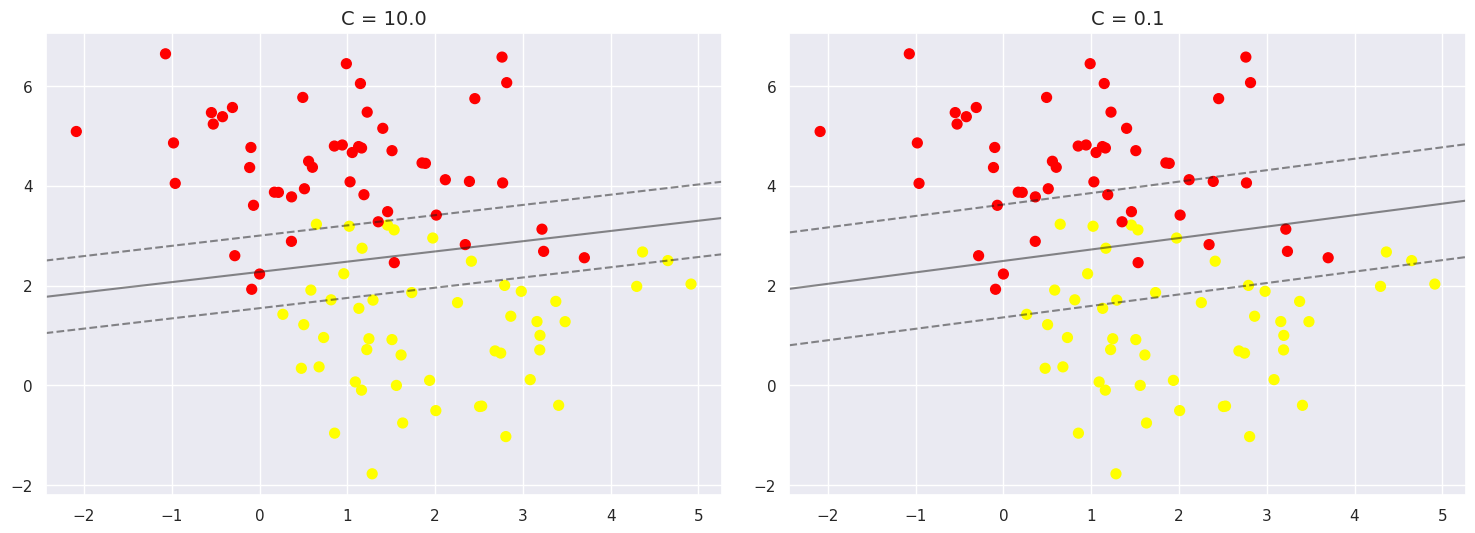

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

El valor óptimo para C es dependiente de los datos que se están analizando, existen estrategias que ayudan en su búsqueda que se explicarán más adelante en la asignatura.

#### Más allá de los límites lineales: *Kernel Trick*

Donde SVM se vuelve extremadamente poderoso es cuando se combina con *kernels*.
Usando *kernels* podemos proyectar los datos en un espacio de dimensiones superiores definido por polinomios y funciones de base gaussiana.

Esta idea surge de la necesidad de que hay conjuntos de datos que no se pueden separar linealmente.

Veamos un ejemplo.

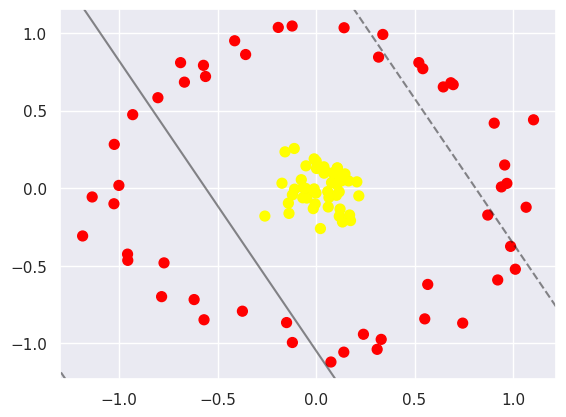

In [78]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Se ve claramente que ninguna discriminación lineal podrá separar estos datos. Pero podemos pensar en cómo proyectar los datos en una dimensión superior de modo que un separador lineal sería suficiente.

Por ejemplo, una proyección simple que podríamos usar sería calcular una función de base radial centrada en el grupo medio:

In [79]:
r = np.exp(-(X ** 2).sum(1))
print(r)

[0.96996719 0.43020984 0.3943785  0.9517097  0.99929922 0.4005588
 0.98845462 0.95572825 0.33649133 0.39059416 0.98808055 0.34731693
 0.36698436 0.98548799 0.92316413 0.30934435 0.33405866 0.971523
 0.93689068 0.36624751 0.98985674 0.41184165 0.97042968 0.38944714
 0.33045007 0.38499114 0.34164546 0.40713959 0.95470628 0.99905039
 0.33152097 0.98378284 0.97961066 0.9430612  0.27346347 0.43430188
 0.98182643 0.46401601 0.32335842 0.98130822 0.99228089 0.98128408
 0.3631054  0.31556638 0.98289304 0.98737297 0.99177983 0.33354414
 0.45363248 0.98898842 0.49380108 0.97214214 0.97132916 0.32942669
 0.30109023 0.98391938 0.32738122 0.2430776  0.9710193  0.26990754
 0.96772744 0.99556671 0.39438297 0.27316047 0.36987999 0.9827339
 0.98582072 0.98111547 0.33514358 0.99134034 0.39550023 0.99255783
 0.9937902  0.96932087 0.43676899 0.41223919 0.96468602 0.39058015
 0.99165674 0.32251135 0.95645997 0.28394231 0.3446655  0.92499406
 0.92869423 0.32255317 0.99714701 0.41879413 0.22269104 0.90487371

Podemos visualizar estos datos con una dimensión extra utilizando un gráfico de 3 dimensiones.

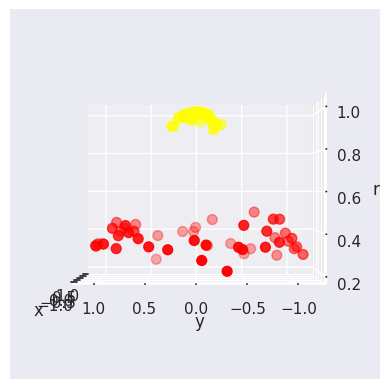

In [80]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D(elev=0, azim=180, X=X, y=y)

Puedes probar a cambiar el valor de elev para ver el gráfico con distinta perspectiva, puedes pensar este valor como el grado de inclinación del gráfico.

EJERCICIO: copia el código necesario y cambia el valor de *elev* a 30 para visualizar el gráfico desde distinto ángulo.

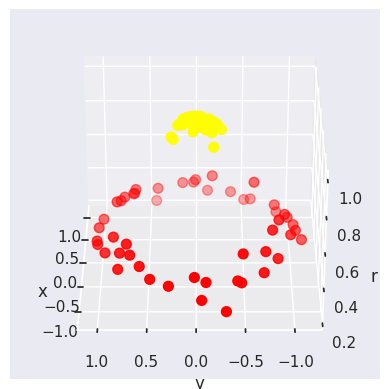

In [81]:
plot_3D(elev=30, azim=180, X=X, y=y)

Con esta dimensión adicional, los datos se vuelven linealmente separables, dibujando un plano de separación en, digamos, r = 0,7.

Esta proyección hay que hacerla con cuidado ya que si no hubiéramos centrado nuestra función de base radial en la ubicación correcta, no se verían resultados tan limpios y linealmente separables. En general, la necesidad de hacer esta elección es un problema.

Una estrategia para este fin es calcular una función base centrada en cada punto del conjunto de datos y dejar que el algoritmo SVM revise los resultados. Este tipo de transformación se conoce como transformación de kernel, ya que se basa en una relación de similitud (o kernel) entre cada par de puntos.

Un problema potencial con esta estrategia (proyectar N puntos en N dimensiones) es que podría volverse cara computacionalmente a medida que N crece. Sin embargo, debido a un procedimiento conocido como kernel trick, se puede realizar un ajuste en los datos transformados del kernel de manera implícita, es decir, sin construir nunca la representación N-dimensional completa de la proyección del kernel.

El método kernel trick está integrado en SVM y es una de las razones por las que el método es tan poderoso.

Usando Scikit-Learn, podemos simplemente cambiar el kernel lineal a un kernel RBF (función de base radial), usando el hiperparámetro del modelo de kernel.

Veamos como quedaría el ejemplo anterior.

In [82]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

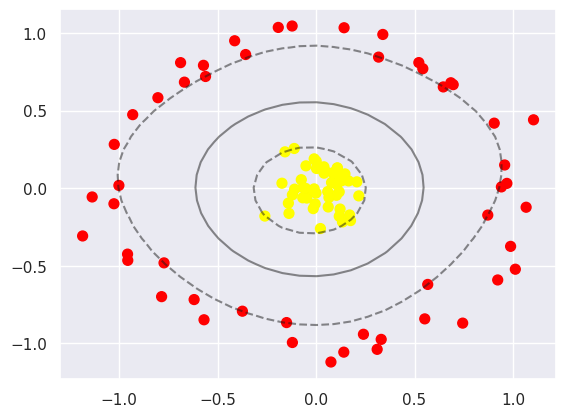

In [83]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

#### Algunos tipos de *kernel*


A continuación vamos a ver que más tipos de *kernel* hay y cómo usarlos.

Para ello vamos a cargar las librerías necesarias:

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.datasets import make_classification

Creamos una nueva muestra aleatoria de dos dimensiones y 200 instancias y la mostramos en un gráfico.

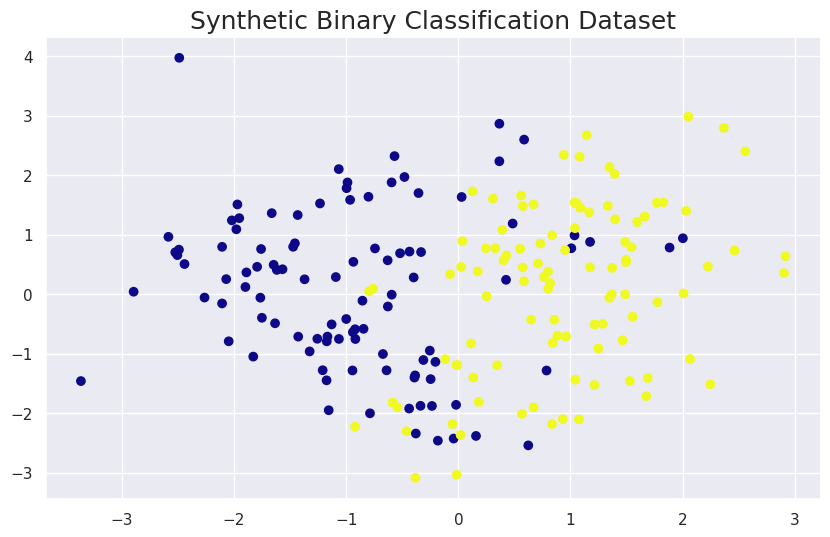

In [85]:
X, y = make_classification(n_samples=200, n_features=2,
n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,random_state=42)
plt.figure(figsize=(10,6))
plt.title("Synthetic Binary Classification Dataset", fontsize=18)
plt.scatter(X[:,0], X[:,1], c=y, cmap='plasma')

Para ello vamos a ver los distintos tipos de kernels que se pueden usar y cómo afectan sus hiperparámetros en los resultados.

##### Kernel: Lineal

Este tipo de *kernel* es el que hemos visto principalmente, su hiperparámetro más importante es C, que mide la permisividad de los márgenes.

Para un valor de C=0.1 obtenemos el siguiente gráfico dónde sobre los datos originales se muestra la frontera de decisión y el margen.

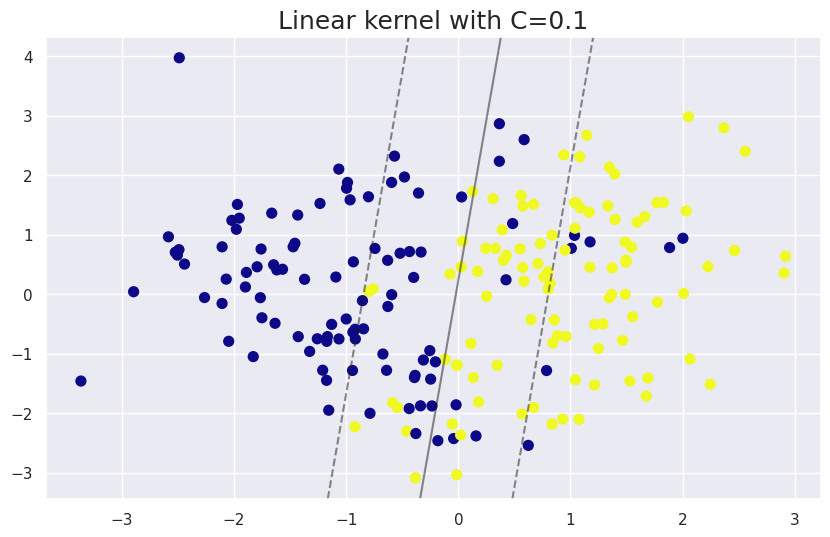

In [86]:
clf = SVC(C=0.1, kernel='linear').fit(X, y)
plt.figure(figsize=(10,6))
plt.title("Linear kernel with C=0.1", fontsize=18)
#dibuja la frontera de decisión y los márgenes sobre el conjunto original de datos
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
plot_svc_decision_function(clf)

Ahora, veamos cómo es la predicción de los datos con esta frontera de decisión.

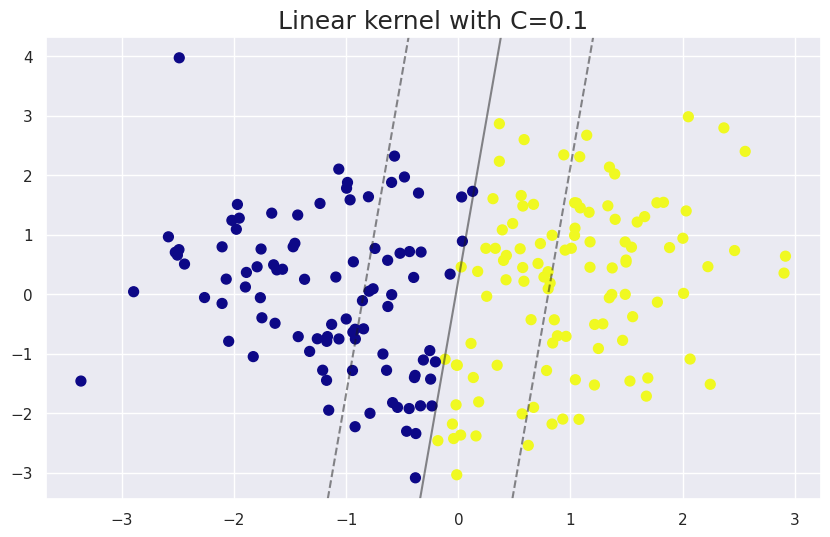

In [87]:
clf = SVC(C=0.1, kernel='linear').fit(X, y)
y_pred = clf.predict(X)
plt.figure(figsize=(10,6))
plt.title("Linear kernel with C=0.1", fontsize=18)
#dibuja la frontera de decisión y los márgenes sobre el conjunto predicho de datos
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
plot_svc_decision_function(clf)

Observa que los datos que están a la izquierda de la frontera han pasado todos a ser de la clase cyan y los que están a la derecha ahora son todos de la clase amarilla.

Creamos un único panel con los dos gráficos para poder comparar mejor y ver qué puntos (o instancias) han cambiado de clase.

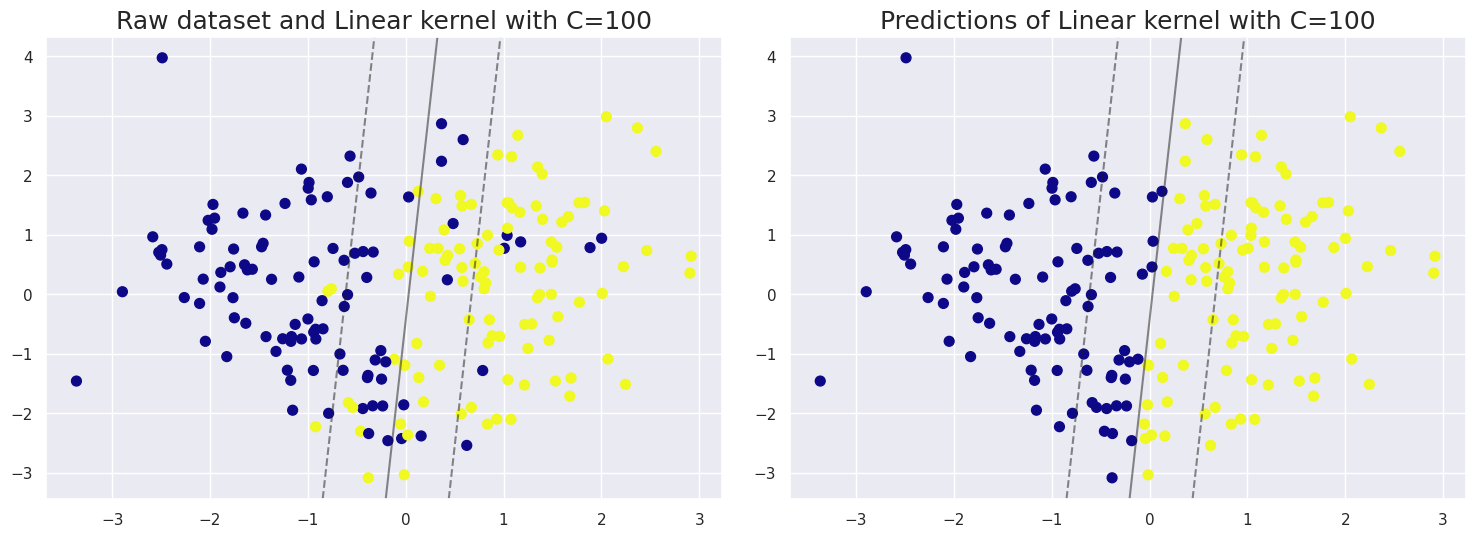

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, o in zip(ax, [0, 1]):
    model = SVC(C=100, kernel='linear').fit(X, y)
    if o==0:
     axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
     axi.set_title("Raw dataset and Linear kernel with C=100", fontsize=18)
    else:
      y_pred = model.predict(X)
      axi.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
      axi.set_title("Predictions of Linear kernel with C=100", fontsize=18)
    plot_svc_decision_function(model, axi)

EJERCICIO: calcula que ocurre para el valor de C=0.01 y calcula la accuracy para los casos en los que C vale {0.01, 0.1, 100}. ¿Qué conclusión se puede sacar cuando el valor de C disminuye?

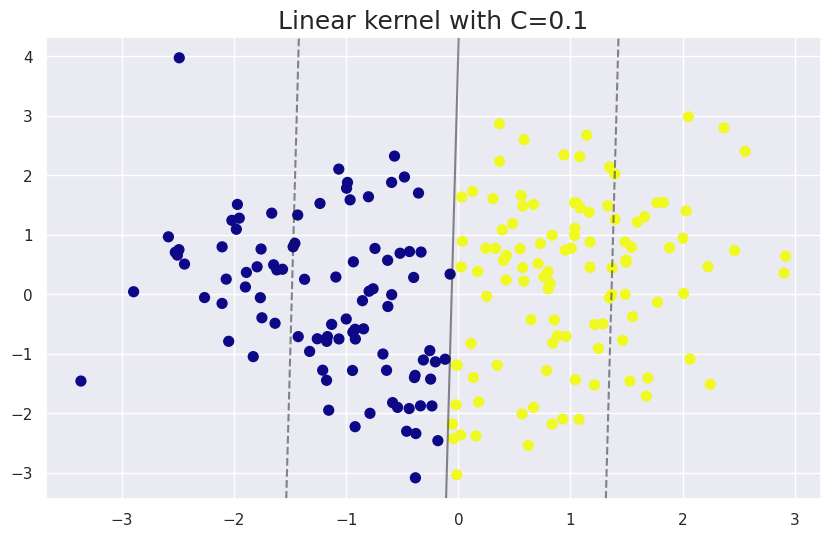

In [89]:
clf = SVC(C=0.01, kernel='linear').fit(X, y)
y_pred = clf.predict(X)
plt.figure(figsize=(10,6))
plt.title("Linear kernel with C=0.1", fontsize=18)
#dibuja la frontera de decisión y los márgenes sobre el conjunto predicho de datos
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
plot_svc_decision_function(clf)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.8, random_state= 1)

clf001 = SVC(C=0.01, kernel='linear').fit(X_train, y_train)
clf = SVC(C=0.1, kernel='linear').fit(X_train, y_train)
clf100 = SVC(C=100, kernel='linear').fit(X_train, y_train)

pred001 = clf001.predict(X_test)
pred = clf.predict(X_test)
pred100 = clf100.predict(X_test)

s1 = accuracy_score(y_test, pred001)
s2 = accuracy_score(y_test, pred)
s3 = accuracy_score(y_test, pred100)
print('Accuracy 0.01:\n', s1)
print('Accuracy 0.1:\n', s2)
print('Accuracy 100:\n', s3)



Accuracy 0.01:
 0.475
Accuracy 0.1:
 0.84375
Accuracy 100:
 0.85


RESPUESTA: Se puede sacar la conclusión de que la precisión disminuye cuando menor sea la C. Esto se debe a que hay una menor permisividad en los márgenes y a un posible sobreajuste.

##### Kernel: RBF (Radial Basis Function)

Como hemos visto anteriormente este kernel es recomendable para cuando hay datos que no son linealmente separables.

Tiene dos hiperparámetros principales C y gamma. C al igual que antes, marca la permisividad del margen. Gamma, de forma intuitiva, define hasta dónde llega la influencia de un solo ejemplo de entrenamiento. Los valores bajos significan "lejos" y los valores altos significan "cerca". El parámetro gamma puede verse como la inversa del radio de influencia de las muestras seleccionadas por el modelo, como los support vectors.

A continuación vemos un ejemplo de como quedaría la frontera de decisión y la predicción con C=1 y gamma=0.01.

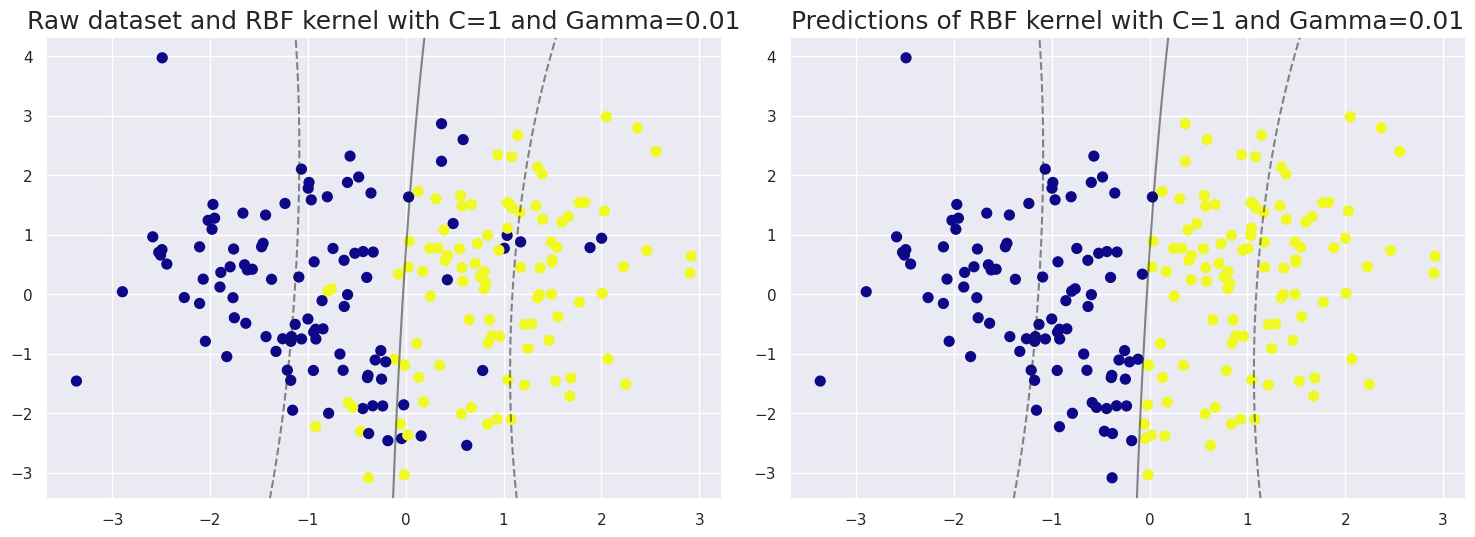

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, o in zip(ax, [0, 1]):
    model = SVC(C=1, kernel='rbf', gamma=0.01).fit(X, y)
    if o==0:
     axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
     axi.set_title("Raw dataset and RBF kernel with C=1 and Gamma=0.01", fontsize=18)
    else:
      y_pred = model.predict(X)
      axi.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
      axi.set_title("Predictions of RBF kernel with C=1 and Gamma=0.01", fontsize=18)
    plot_svc_decision_function(model, axi)

Cambiamos el valor de gamma a 0.01 y dejamos C como está. Veamos qué ocurre ahora.

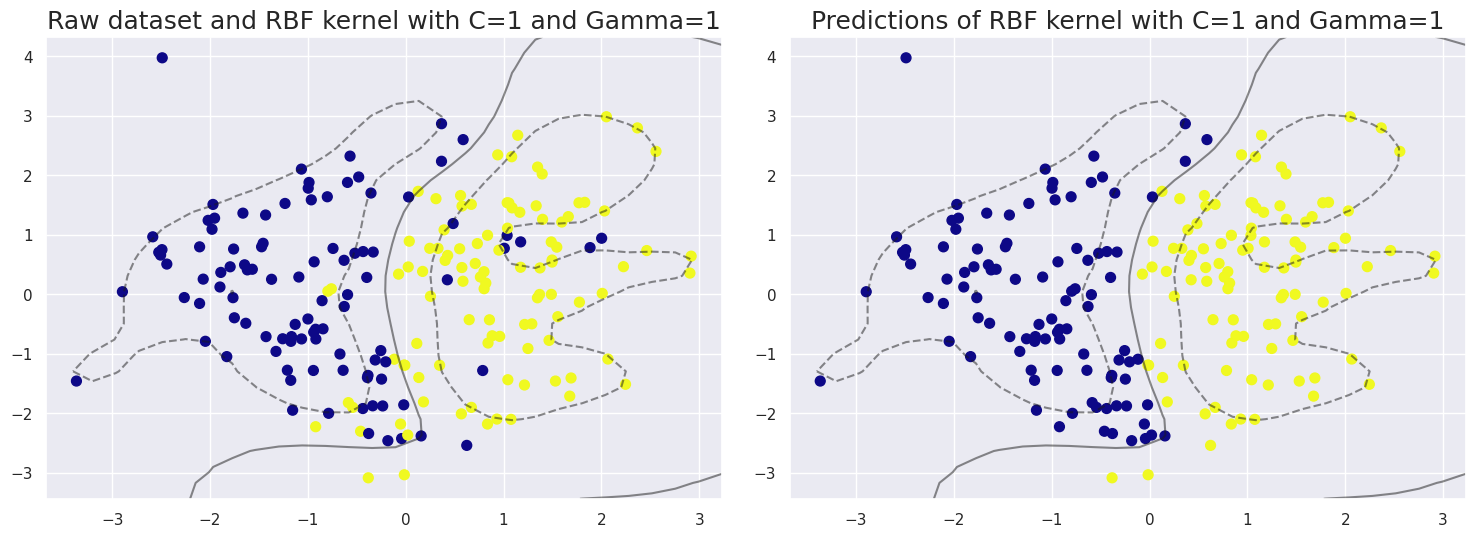

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, o in zip(ax, [0, 1]):
    model = SVC(C=1, kernel='rbf', gamma=1).fit(X, y)
    if o==0:
     axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
     axi.set_title("Raw dataset and RBF kernel with C=1 and Gamma=1", fontsize=18)
    else:
      y_pred = model.predict(X)
      axi.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
      axi.set_title("Predictions of RBF kernel with C=1 and Gamma=1", fontsize=18)
    plot_svc_decision_function(model, axi)

EJERCICIO: comprueba qué ocurre cuando usas el kernel RBF y valores de C=1 y de gamma 5. ¿Crees que está bien? En caso de que la respuesta sea negativa, ¿qué problema crees que tiene este modelo?

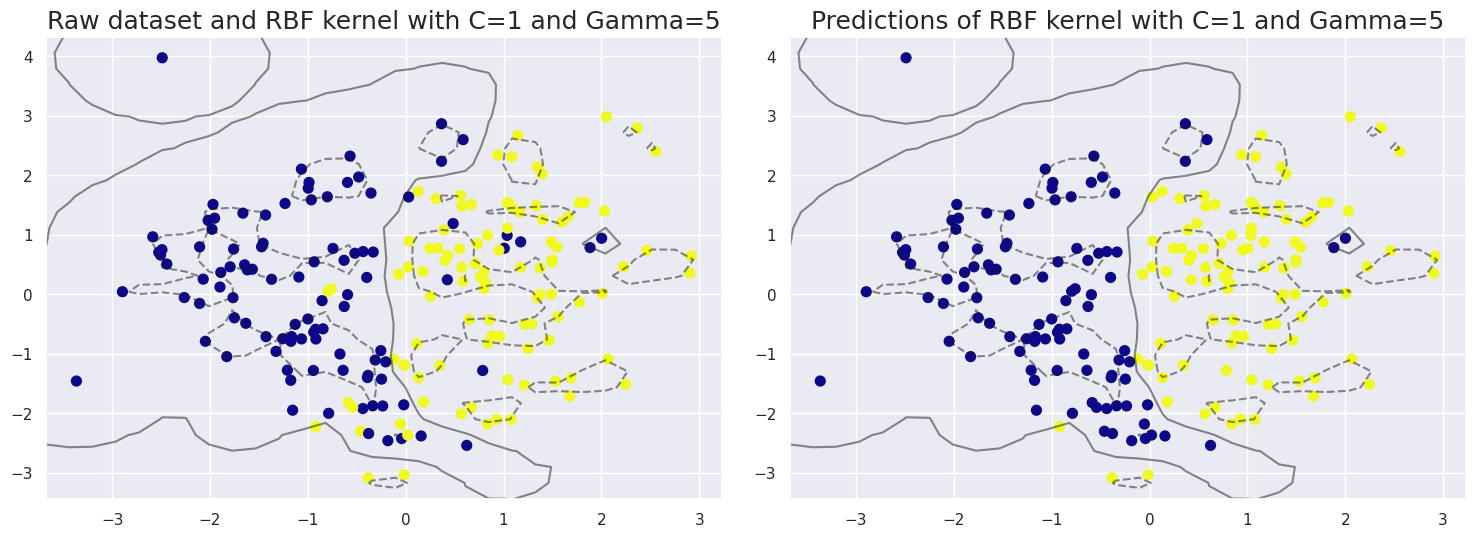

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, o in zip(ax, [0, 1]):
    model = SVC(C=1, kernel='rbf', gamma=5).fit(X, y)
    if o==0:
     axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
     axi.set_title("Raw dataset and RBF kernel with C=1 and Gamma=5", fontsize=18)
    else:
      y_pred = model.predict(X)
      axi.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
      axi.set_title("Predictions of RBF kernel with C=1 and Gamma=5", fontsize=18)
    plot_svc_decision_function(model, axi)

RESPUESTA: Creo que con un gamma tan alto hay demasiado sobreajuste.

EJERCICIO: Para los valores de gamma {0.01, 1 y 5} calcula la accuracy y comprueba con los resultados lo que hemos visto en las gráficas. ¿Qué accuracy crees que saldrá al poner un valor de gamma muy alto, por ejemplo 20? ¿y 55?

In [100]:
from os import PRIO_PGRP
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.8, random_state= 1)

model01= SVC(C=1, kernel='rbf', gamma=0.01).fit(X_train, y_train)
model1= SVC(C=1, kernel='rbf', gamma=1).fit(X_train, y_train)
model5= SVC(C=1, kernel='rbf', gamma=5).fit(X_train, y_train)
model20= SVC(C=1, kernel='rbf', gamma=20).fit(X_train, y_train)
model55= SVC(C=1, kernel='rbf', gamma=55).fit(X_train, y_train)

pred01 = model01.predict(X_test)
pred1 = model1.predict(X_test)
pred5 = model5.predict(X_test)
pred20 = model20.predict(X_test)
pred55 = model55.predict(X_test)

s01 = accuracy_score(y_test, pred01)
s1 = accuracy_score(y_test, pred1)
s5 = accuracy_score(y_test, pred5)
s20 = accuracy_score(y_test, pred20)
S55 = accuracy_score(y_test, pred55)

print('Accuracy 0.01:\n', s01)
print('Accuracy 1:\n', s1)
print('Accuracy 5:\n', s5)
print('Accuracy 20:\n', s20)
print('Accuracy 55:\n', S55)

Accuracy 0.01:
 0.48125
Accuracy 1:
 0.81875
Accuracy 5:
 0.75625
Accuracy 20:
 0.6
Accuracy 55:
 0.5125


El mejor accuracy se ha obtenido con un gamma = 1, esto se debe a que así se minimiza tanto el sesgo como el sobreajuste. A medida de que se reduce este valor aumenta el sesgo y el accuracy es menor, y a medida que se aumenta, aumenta el sobrejuste y el accuracy es menor también.

##### Kernel: Poly (Polynomial)

Intuitivamente, el *kernel* polinomial además de mirar las características de las muestras de entrada para determinar su similitud, también mira las combinaciones de estas.
Sus hiperparámetros más importantes son C y el grado del polinomio (*degree*).

Veamos cómo queda nuestro ejemplo usando un *kernel* polinomial de grado 2.

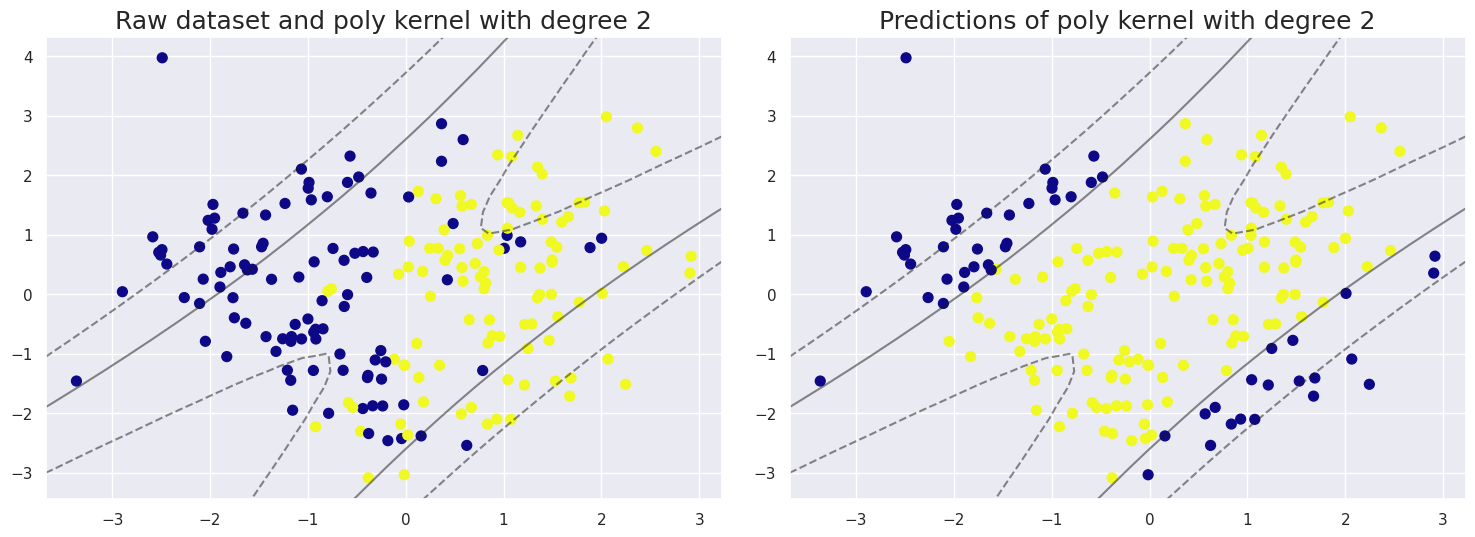

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, o in zip(ax, [0, 1]):
    model = SVC(C=1, kernel='poly', degree=2).fit(X, y)
    if o==0:
     axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma')
     axi.set_title("Raw dataset and poly kernel with degree 2", fontsize=18)
    else:
      y_pred = model.predict(X)
      axi.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='plasma')
      axi.set_title("Predictions of poly kernel with degree 2", fontsize=18)
    plot_svc_decision_function(model, axi)

EJERCICIO: Prueba con distintos grados {1,3,4,5} y calcula la accuracy para el grado 2 y para los grados anteriores. ¿Cuál da una mejor solución?

In [103]:
model1 = SVC(C=1, kernel='poly', degree=1).fit(X_train, y_train)
model2 = SVC(C=1, kernel='poly', degree=2).fit(X_train, y_train)
model3 = SVC(C=1, kernel='poly', degree=3).fit(X_train, y_train)
model4 = SVC(C=1, kernel='poly', degree=4).fit(X_train, y_train)
model5 = SVC(C=1, kernel='poly', degree=5).fit(X_train, y_train)

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
pred4 = model4.predict(X_test)
pred5 = model5.predict(X_test)

s1 = accuracy_score(y_test, pred1)
s2 = accuracy_score(y_test, pred2)
s3 = accuracy_score(y_test, pred3)
s4 = accuracy_score(y_test, pred4)
s5 = accuracy_score(y_test, pred5)

print('Accuracy 1:\n', s1)
print('Accuracy 2:\n', s2)
print('Accuracy 3:\n', s3)
print('Accuracy 4:\n', s4)
print('Accuracy 5:\n', s5)

Accuracy 1:
 0.86875
Accuracy 2:
 0.475
Accuracy 3:
 0.75625
Accuracy 4:
 0.46875
Accuracy 5:
 0.69375


El mejor resultado se obtiene con grado 1, esto se debe a que la mejor forma de dividir el conjunto de datos es con una recta.

Estos que hemos visto son algunos tipos de *kernel* pero puedes encontrar más información sobre cuáles son y cómo usarlos [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

## Ejercicio Extra

Rescatamos el dataset sobre el vino de la práctica 2 y sobre los datos binarizados (clases "good" y "bad") aplica al menos una vez cada uno de los modelos estudiados en esta práctica (NB, DT y SVM). Puedes jugar con alguno de sus hiperparámetros para ver si mejora el resultado.
Obtén también alguna métrica como la *accuracy* para poder comparar los modelos creados.

De los que has probado, ¿cuál dirías que es mejor? Alguno de estos métodos mejora el resultado obtenido con el método kNN en la práctica 2?.

Consideramos las librerías, la lectura de datos, la división de los datos en train y test, y el escalado de los datos tal cual lo hicimos en la práctica 2.

In [131]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt


In [132]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')

# Mostrar las 10 primeras filas del dataset
print(df.head(10))
# Comprobamos la dimensión del dataset
print(df.shape)
# Obtenemos el tipo de cada una de sus features
print(df.info())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0

In [133]:
# Dividir las instancias del vino como 'good' y 'bad' a partir de la característica "quality"
bins = (2, 5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)
# Asignamos una etiqueta a "quality"
label_quality = LabelEncoder()
# Bad tomará el valor 0 y good será el valor 1
df['quality'] = label_quality.fit_transform(df['quality'])
print(df['quality'].value_counts())


quality
1    855
0    744
Name: count, dtype: int64


In [134]:
#creamos una variable X que tendrá las características de nuestros datos menos la variable objetivo
X = df.drop('quality', axis=1)
#creamos una variable y que tendrá sólo la variable objetivo
y = df['quality']

In [124]:
#Cambiar para usar el mismo de la práctica 3. Aquí aparece el conjunto de entrenamiento y testeo (80-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle = True) #se puede usar determinando el tamaño del conjunto de train "train_size"

In [125]:

# Escala los conjuntos de train y test centrandolos en 0 y obteniendo una desviación estándar de 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
# Escala los conjuntos de train y test centrandolos en 0 y obteniendo una desviación estándar de 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [127]:
# Crea los modelos
# 1. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy Naive Bayes: {accuracy_nb:.2f}")


Accuracy Naive Bayes: 0.74


In [130]:
# 2. Árbol de decisión
from sklearn.model_selection import GridSearchCV
# Definir la cuadrícula de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 10, None],         # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],      # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4],        # Número mínimo de muestras necesarias en una hoja
    'criterion': ['gini', 'entropy']      # Función para medir la calidad de la división
}

# Configurar GridSearchCV
dt = DecisionTreeClassifier(random_state=1)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,   # Validación cruzada con 5 particiones
    verbose=1,
    n_jobs=-1
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evaluar el modelo con los mejores hiperparámetros
best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy Decision Tree optimizado: {accuracy_dt:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy Decision Tree optimizado: 0.78


In [129]:
# 3. SVM
# Definir la cuadrícula de hiperparámetros manualmente
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1]
gamma_values = [0.1, 1]
degrees = [1, 3, 5]

# Variables para guardar el mejor modelo
best_accuracy = 0
best_params = {}

# Entrenamiento iterativo sobre los hiperparámetros
for kernel in kernels:
    for C in C_values:
        for gamma in gamma_values:
            for degree in degrees:
                if kernel != 'poly' and degree > 1:  # 'degree' solo aplica a kernel 'poly'
                    continue

                # Crear y ajustar el modelo
                svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
                svm.fit(X_train, y_train)

                # Predecir y calcular precisión
                y_pred_svm = svm.predict(X_test)
                accuracy_svm = accuracy_score(y_test, y_pred_svm)

                # Guardar el mejor modelo
                if accuracy_svm > best_accuracy:
                    best_accuracy = accuracy_svm
                    best_params = {'kernel': kernel, 'C': C, 'gamma': gamma, 'degree': degree}

# Mostrar los mejores parámetros y la precisión
print("Mejores hiperparámetros:", best_params)
print(f"Accuracy SVM optimizado: {best_accuracy:.2f}")

Mejores hiperparámetros: {'kernel': 'rbf', 'C': 1, 'gamma': 1, 'degree': 1}
Accuracy SVM optimizado: 0.77


El mejor accuracy se ha obtenido con el decision tree, siendo este de un 78%. Siendo este menor que el mejor obtenido por el knn de la anterior práctica